# 04 — Interpretación física + frecuencia de eventos + Isolation Forest (robusto)

## Objetivo
Con los datos a $\Delta t\approx 1$ minuto, queremos:

1. Interpretar físicamente **aperturas** y **cierres** de demanda usando horizontes fijos:
   - baseline en $t_0-1$ min y evaluación en $h=\{0,4,8,12,16\}$ min.
2. Separar eventos en familias hidráulicas:
   - **pulso**: el caudal vuelve cerca del baseline a 16 min
   - **persistente**: el caudal mantiene el cambio a 16 min
   - **intermedio**
3. Medir **frecuencia** (conteos por día/mes/hora), tiempos entre eventos y **ciclos** apertura→cierre (proxy de fatiga).
4. Detectar eventos **anómalos** con Isolation Forest usando features físicos y escalado robusto.

---

## Glosario (notación)
- $P_g(t)$: presión manométrica (gauge) [bar]
- $P_{abs}(t)\approx P_g(t)+P_{atm}$: presión absoluta [bar]
- $Q(t)$: caudal [L/s]
- $D=0.315$ m, $A=\pi D^2/4$
- $V(t)=Q/A$
- $\Delta Q_h = Q(t_0+h)-Q(t_0-1)$
- $\Delta P_h = P_g(t_0+h)-P_g(t_0-1)$
- $\rho_f$: densidad del fluido (agua) [kg/m³]

---

## Marco físico (qué sí/qué no podemos ver)
- Un **golpe de ariete** ideal cumple, a escala muy rápida:
  $$
  \Delta P \approx \rho_f\,a\,\Delta V
  $$
  (Joukowsky; $a$ típico del orden $10^2$–$10^3$ m/s según fluido/tubería).
- Con muestreo **1-min**, los transientes de segundos se ven como:
  - escalones/rampas
  - cambios de nivel de presión asociados a pérdidas y/o control
  - algunos colapsos “cerca de 0 bar gauge” si ocurren

En este notebook usamos un **proxy**:
$$
a_{app}=\frac{|\Delta P|}{\rho_f\,|\Delta V|}
$$
calculado con horizontes (ej. $h=4$ min). Si $a_{app}$ resulta muy bajo respecto a valores típicos, sugiere que lo observado es más bien **respuesta cuasi-estacionaria** (pérdidas/operación) y no la onda rápida pura.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)

PROJECT_ROOT = Path('/home/maxi/datascience_esval')

HORIZ_FILE = PROJECT_ROOT / 'data' / 'processed' / 'eventos_apertura_cierre_horizontes.parquet'
EVENTS_FILE = PROJECT_ROOT / 'data' / 'processed' / 'eventos_apertura_cierre.parquet'

OUT_LABELED = PROJECT_ROOT / 'data' / 'processed' / 'eventos_iforest_labeled.parquet'
OUT_ANOMS   = PROJECT_ROOT / 'data' / 'processed' / 'iforest_anomalias.parquet'

HORIZ_FILE.exists(), EVENTS_FILE.exists(), HORIZ_FILE, EVENTS_FILE


(True,
 True,
 PosixPath('/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre_horizontes.parquet'),
 PosixPath('/home/maxi/datascience_esval/data/processed/eventos_apertura_cierre.parquet'))

## 1) Carga y unión de tablas

- `horiz`: una fila por evento con horizontes (baseline -1 y 0/4/8/12/16)
- `events`: métricas dentro de la ventana del evento (min/max de $\Delta P$, min/max de $P_g$)

Unimos por (`type`, `start`) para tener todo en una sola tabla.


In [2]:
horiz = pd.read_parquet(HORIZ_FILE)
events = pd.read_parquet(EVENTS_FILE)

horiz['start'] = pd.to_datetime(horiz['start'])
horiz['end']   = pd.to_datetime(horiz['end'])
events['start'] = pd.to_datetime(events['start'])
events['end']   = pd.to_datetime(events['end'])

# merge (si existiera duplicación rara, quedará la primera coincidencia)
df = horiz.merge(
    events[['type','start','min_dP_bar','max_dP_bar','min_P_bar','max_P_bar','max_abs_dQ_1min_lps']],
    on=['type','start'],
    how='left'
)

df.shape, df['type'].value_counts().to_dict()


((2658, 25), {'cierre': 1555, 'apertura': 1103})

## 2) Features físicos (magnitud, persistencia, proxy de onda)

Usamos principalmente $h=4$ y $h=16$:

- magnitudes:
  - $|\Delta Q_4|$, $|\Delta P_4|$, $|\Delta Q_{16}|$, $|\Delta P_{16}|$
- persistencia:
  $$
  R=\frac{|\Delta Q_{16}|}{\max(|\Delta Q_{4}|,\epsilon)}
  $$
- familias:
  - **pulso**: $R\le 0.2$ (tiende a volver)
  - **persistente**: $R\ge 0.7$
  - **intermedio**: resto
- proxy de “water hammer”:
  $$
  a_{app,4}=\frac{|\Delta P_4|}{\rho_f\,|\Delta V_4|}
  $$
con:
$$
\Delta V_4 = \frac{\Delta Q_4}{A}
$$
(considerando unidades consistentes).


In [3]:
# geometría y constantes
D = 0.315
A = np.pi*(D**2)/4
rho_f = 1000.0
BAR_TO_PA = 1e5

# columnas horizonte
dQ4  = 'dQ_4min_lps'
dP4  = 'dP_4min_bar'
dQ16 = 'dQ_16min_lps'
dP16 = 'dP_16min_bar'

for c in [dQ4,dP4,dQ16,dP16]:
    if c not in df.columns:
        raise KeyError(f'Falta columna esperada en df: {c}')

# magnitudes
df['abs_dQ4']  = df[dQ4].abs()
df['abs_dP4']  = df[dP4].abs()
df['abs_dQ16'] = df[dQ16].abs()
df['abs_dP16'] = df[dP16].abs()

# persistencia
eps = 1e-6
df['R_persist'] = df['abs_dQ16'] / np.maximum(df['abs_dQ4'], eps)

def family(R):
    if pd.isna(R):
        return 'na'
    if R <= 0.20:
        return 'pulso'
    if R >= 0.70:
        return 'persistente'
    return 'intermedio'

df['family'] = df['R_persist'].apply(family)

# a_app usando h=4 (ΔP4 bar -> Pa; ΔV4: ΔQ4 L/s -> m3/s y /A)
dV4 = (df[dQ4] / 1000.0) / A
df['abs_dV4'] = dV4.abs()
df['a_app_4_ms'] = (df['abs_dP4'] * BAR_TO_PA) / (rho_f * np.maximum(df['abs_dV4'], eps))

# flags útiles
df['day'] = df['start'].dt.floor('D')
df['hour'] = df['start'].dt.hour
df['month'] = df['start'].dt.to_period('M').astype(str)

# sanity
df[['type','family','abs_dQ4','abs_dQ16','R_persist','a_app_4_ms','min_dP_bar','max_dP_bar']].head()


,type,family,abs_dQ4,abs_dQ16,R_persist,a_app_4_ms,min_dP_bar,max_dP_bar
0,cierre,persistente,21.10,21.33,1.010900,4.063891,-0.051014,0.025007
1,apertura,intermedio,22.03,6.29,0.285520,242.032363,-0.730203,0.066018
2,cierre,persistente,19.92,19.73,0.990462,304.454291,-0.030008,0.679189
3,apertura,pulso,20.01,2.71,0.135432,101.677593,-0.222062,0.030008
4,apertura,intermedio,19.67,4.02,0.204372,258.785928,-0.701195,0.043012


## 3) Interpretación física: lo que dicen los números

### 3.1 Distribución de familias (pulso/persistente)
- Si predominan **pulsos**, el sistema ve muchos ciclos de presión (relevante para fatiga/SCG).
- Si predominan **persistentes**, estamos viendo cambios de régimen (operación/control).

### 3.2 Magnitud típica de respuesta a 4 min
- Aperturas: típicamente $\Delta P_4 < 0$ (baja presión por aumento de caudal/pérdidas)
- Cierres: típicamente $\Delta P_4 > 0$

### 3.3 Proxy $a_{app,4}$
- Si $a_{app,4}$ sale del orden **decenas–centenas** m/s, sugiere respuesta “lenta” (pérdidas/operación) a escala minuto.
- Valores muy altos pueden indicar:
  - evento real muy rápido submuestreado
  - cambio de operación (bomba/válvula) que mueve presión mucho más que el caudal medido
  - dato anómalo

Vamos a cuantificar esto con plots y percentiles.


family,intermedio,na,persistente,pulso
type,,,,
apertura,159,17,172,755
cierre,66,20,1417,52



=== APERTURA ===
n: 1103


count    1098.000000
mean       21.826840
std        10.273732
min         0.200000
50%        21.870000
90%        28.861000
95%        31.126000
99%        69.702900
99.9%      84.273070
max        86.790000
Name: abs_dQ4, dtype: float64

count    1096.000000
mean        0.242984
std         0.212044
min         0.000000
50%         0.207558
90%         0.610170
95%         0.740456
99%         1.046391
99.9%       1.301937
max         1.315366
Name: abs_dP4, dtype: float64

count    1095.000000
mean       96.125045
std        96.661608
min         0.000000
50%        76.182915
90%       217.161287
95%       267.355722
99%       481.156538
99.9%    1107.213523
max      1169.292315
Name: a_app_4_ms, dtype: float64


=== CIERRE ===
n: 1555


count    1550.000000
mean       22.102277
std         7.838891
min         0.090000
50%        21.805000
90%        28.111000
95%        30.041000
99%        48.812300
99.9%      82.614120
max        83.090000
Name: abs_dQ4, dtype: float64

count    1546.000000
mean        0.276454
std         0.179649
min         0.000000
50%         0.249069
90%         0.477133
95%         0.726952
99%         0.819178
99.9%       1.067402
max         1.192332
Name: abs_dP4, dtype: float64

count    1546.000000
mean      112.027554
std       273.890761
min         0.000000
50%        88.670118
90%       162.155630
95%       270.525108
99%       347.169653
99.9%    2334.389252
max      9702.638358
Name: a_app_4_ms, dtype: float64

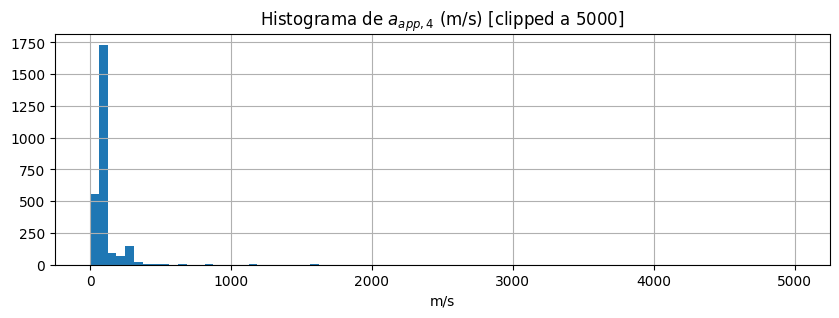

In [4]:
# familias por tipo
fam_tab = (df.groupby(['type','family']).size().unstack(fill_value=0))
display(fam_tab)

# percentiles clave por tipo/familia
def desc(s):
    return s.describe(percentiles=[0.5,0.9,0.95,0.99,0.999])

for typ in ['apertura','cierre']:
    sub = df[df['type']==typ]
    print('\n===', typ.upper(), '===')
    print('n:', len(sub))
    display(desc(sub['abs_dQ4']))
    display(desc(sub['abs_dP4']))
    display(desc(sub['a_app_4_ms']))

# histogramas rápidos
plt.figure(figsize=(10,3))
plt.hist(df['a_app_4_ms'].replace([np.inf,-np.inf], np.nan).dropna().clip(upper=5000), bins=80)
plt.title(r'Histograma de $a_{app,4}$ (m/s) [clipped a 5000]')
plt.xlabel('m/s')
plt.show()


## 4) Frecuencia de eventos (día/mes/hora) e inter-arribos

Para fatiga/SCG, lo crítico es:
- **cuántos ciclos** por unidad de tiempo
- amplitudes (aunque sean moderadas)
- persistencia temporal (¿todos los días? ¿en ciertos horarios?)

Calculamos:
- tasa diaria: eventos/día por tipo y familia
- distribución de tiempos entre eventos (inter-arrival time) por tipo
- mapas por hora (solo conteos, sin interpretar causal todavía)


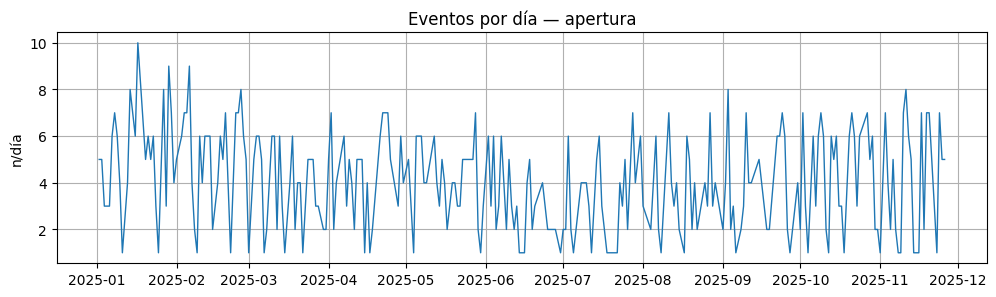

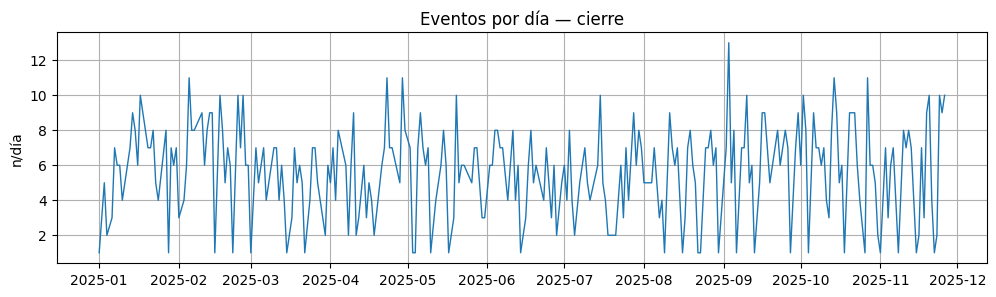

type      apertura                            cierre                       
family  intermedio   na persistente pulso intermedio   na persistente pulso
month                                                                      
2025-01       23.0  7.0        24.0  78.0        7.0  4.0       122.0   4.0
2025-02       25.0  0.0        24.0  82.0        5.0  2.0       144.0   7.0
2025-03       17.0  0.0         8.0  71.0        7.0  4.0       111.0   4.0
2025-04       17.0  4.0        15.0  65.0        6.0  2.0       122.0   4.0
2025-05       15.0  0.0        23.0  60.0        9.0  1.0       123.0   3.0
2025-06       10.0  0.0        11.0  52.0        4.0  1.0       121.0   5.0
2025-07        9.0  0.0        11.0  66.0        9.0  1.0       125.0   1.0
2025-08       10.0  0.0        10.0  59.0        8.0  0.0       120.0   3.0
2025-09       13.0  1.0        10.0  67.0        5.0  1.0       148.0   9.0
2025-10       12.0  2.0        18.0  86.0        4.0  0.0       167.0   5.0
2025-11        8.0  3.0        18.0  69.0        2.0  4.0       114.0   7.0

type     apertura                             cierre                       
family intermedio   na persistente  pulso intermedio   na persistente pulso
hour                                                                       
0             0.0  0.0         3.0    2.0        0.0  0.0         3.0   1.0
1             0.0  1.0         2.0    1.0        0.0  0.0         6.0   0.0
2             0.0  0.0         2.0    2.0        0.0  0.0         8.0   0.0
3             0.0  0.0         0.0    0.0        0.0  0.0         1.0   0.0
4             1.0  0.0         0.0    0.0        0.0  0.0         0.0   0.0
5             0.0  0.0         1.0    0.0        0.0  0.0         1.0   0.0
6             0.0  0.0         2.0    0.0        0.0  0.0         2.0   0.0
7             0.0  0.0         1.0    0.0        1.0  0.0         3.0   0.0
8             2.0  0.0         3.0   15.0        3.0  0.0        22.0   0.0
9            37.0  3.0        31.0  131.0       15.0  1.0       213.0   9.0
10           27.0  2.0        19.0  117.0       13.0  2.0       210.0   7.0
11           29.0  3.0        34.0  114.0        6.0  6.0       196.0  12.0
12           11.0  4.0         9.0   61.0        5.0  2.0       135.0   2.0
13            3.0  0.0         2.0   18.0        1.0  0.0        25.0   0.0
14            4.0  1.0         2.0   26.0        1.0  0.0        55.0   1.0
15            9.0  1.0        15.0  102.0        6.0  4.0       169.0   7.0
16           20.0  1.0        19.0   98.0       11.0  3.0       189.0   9.0
17           11.0  1.0        10.0   46.0        3.0  1.0       119.0   3.0
18            5.0  0.0         3.0    9.0        0.0  0.0        23.0   0.0
19            0.0  0.0         4.0    8.0        0.0  0.0        11.0   0.0
20            0.0  0.0         2.0    1.0        0.0  0.0         6.0   0.0
21            0.0  0.0         3.0    0.0        1.0  0.0         7.0   1.0
22            0.0  0.0         1.0    3.0        0.0  0.0         7.0   0.0
23            0.0  0.0         4.0    1.0        0.0  1.0         6.0   0.0

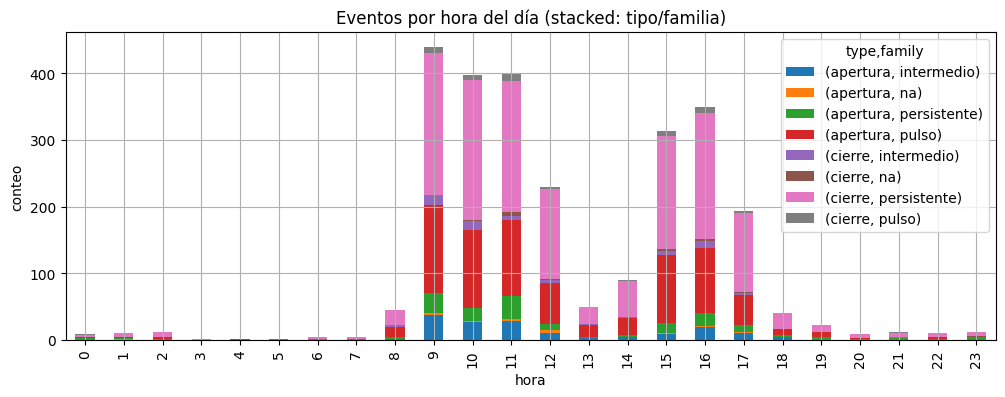

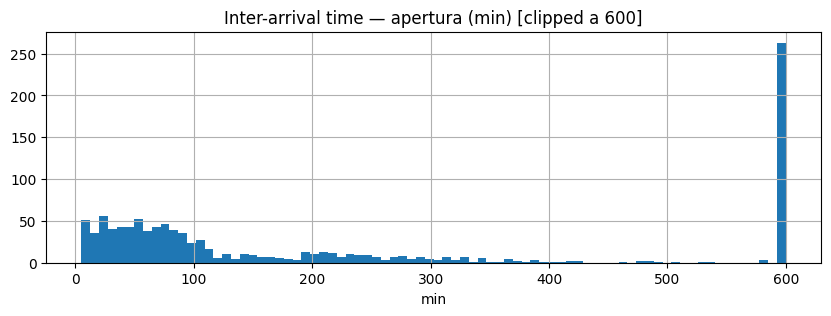

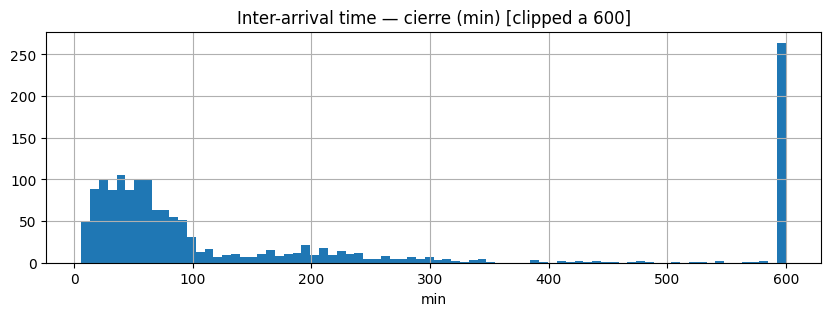

In [5]:
# conteos por día
daily = (df.groupby(['day','type','family']).size()
           .rename('n')
           .reset_index())

# total por día y tipo
daily_tot = (df.groupby(['day','type']).size().rename('n').reset_index())

# plot tasa diaria total por tipo
for typ in ['apertura','cierre']:
    s = daily_tot[daily_tot['type']==typ].set_index('day')['n']
    plt.figure(figsize=(12,3))
    plt.plot(s.index, s.values, linewidth=1)
    plt.title(f'Eventos por día — {typ}')
    plt.ylabel('n/día')
    plt.show()

# conteo por mes y tipo/familia
monthly = (df.groupby(['month','type','family']).size().rename('n').reset_index())
pivot_month = monthly.pivot_table(index='month', columns=['type','family'], values='n', fill_value=0)
display(pivot_month.head(12))

# por hora
hourly = (df.groupby(['hour','type','family']).size().rename('n').reset_index())
pivot_hour = hourly.pivot_table(index='hour', columns=['type','family'], values='n', fill_value=0).reindex(range(24), fill_value=0)
display(pivot_hour)

pivot_hour.plot(kind='bar', stacked=True, figsize=(12,4))
plt.title('Eventos por hora del día (stacked: tipo/familia)')
plt.xlabel('hora')
plt.ylabel('conteo')
plt.show()

# inter-arrival (min) por tipo
for typ in ['apertura','cierre']:
    s = df[df['type']==typ].sort_values('start')['start']
    dt_min = s.diff().dt.total_seconds()/60.0
    plt.figure(figsize=(10,3))
    plt.hist(dt_min.dropna().clip(upper=600), bins=80)
    plt.title(f'Inter-arrival time — {typ} (min) [clipped a 600]')
    plt.xlabel('min')
    plt.show()


## 5) Proxy de ciclos de presión: emparejar apertura→cierre

Una forma práctica (event-based) de aproximar “ciclos”:

- Tomar aperturas **pulso** y buscar el primer cierre posterior dentro de una ventana (ej. 60 min).
- Para cada par, definir amplitud aproximada de ciclo en presión como:
  $$
  \Delta P_{cycle} \approx |\Delta P_{min}^{(open)}| + |\Delta P_{max}^{(close)}|
  $$
usando `min_dP_bar` del evento de apertura y `max_dP_bar` del evento de cierre.

Esto no es rainflow completo, pero es una métrica **física y trazable** para discusión con el profesor.


n aperturas pulso: 755
n cierres pulso: 52
n pares apertura→cierre (<=60 min): 39


,start_open,end_open,start_close,dt_open_to_close_min,dP_cycle_bar
9,2025-01-07 11:35:00,2025-01-07 11:39:00,2025-01-07 11:42:00,3.0,0.373104
22,2025-01-10 08:52:00,2025-01-10 09:01:00,2025-01-10 09:01:00,0.0,0.459128
40,2025-01-17 10:15:00,2025-01-17 10:22:00,2025-01-17 11:06:00,44.0,0.554154
41,2025-01-17 11:00:00,2025-01-17 11:06:00,2025-01-17 11:06:00,0.0,0.335093
71,2025-01-29 15:37:00,2025-01-29 15:40:00,2025-01-29 15:43:00,3.0,0.429119
88,2025-02-05 15:47:00,2025-02-05 15:51:00,2025-02-05 16:02:00,11.0,0.454126
89,2025-02-05 15:58:00,2025-02-05 16:02:00,2025-02-05 16:02:00,0.0,0.418116
91,2025-02-06 10:53:00,2025-02-06 10:59:00,2025-02-06 11:47:00,48.0,0.751209
92,2025-02-06 11:43:00,2025-02-06 11:47:00,2025-02-06 11:47:00,0.0,0.253070
140,2025-02-24 15:34:00,2025-02-24 15:38:00,2025-02-24 15:41:00,3.0,0.397110


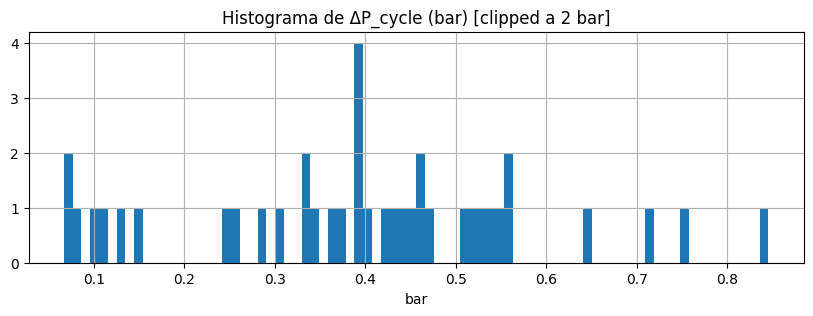

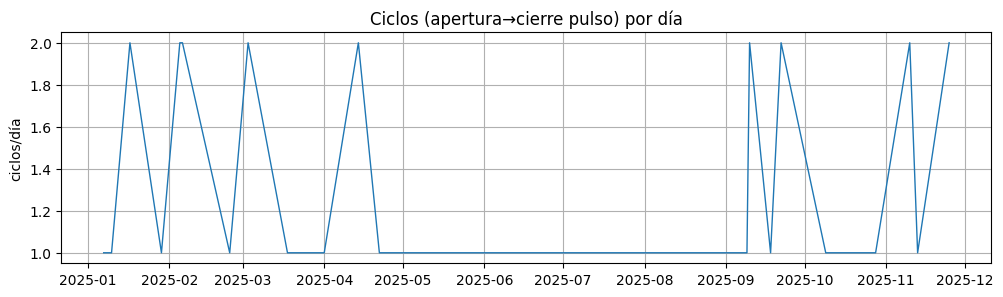

In [6]:
# preparar subconjuntos
opens = df[(df['type']=='apertura') & (df['family']=='pulso')].copy()
closes = df[(df['type']=='cierre') & (df['family']=='pulso')].copy()

opens = opens.sort_values('start')
closes = closes.sort_values('start')

# merge_asof para tomar el primer cierre posterior
paired = pd.merge_asof(
    opens[['start','end','min_dP_bar','abs_dQ4','abs_dP4','dQ_total_lps']].rename(columns={'start':'start_open','end':'end_open','min_dP_bar':'min_dP_open'}),
    closes[['start','end','max_dP_bar','abs_dQ4','abs_dP4','dQ_total_lps']].rename(columns={'start':'start_close','end':'end_close','max_dP_bar':'max_dP_close'}),
    left_on='end_open',
    right_on='start_close',
    direction='forward',
    tolerance=pd.Timedelta(minutes=60)
)

paired['dt_open_to_close_min'] = (paired['start_close'] - paired['end_open']).dt.total_seconds()/60.0
paired['dP_cycle_bar'] = paired['min_dP_open'].abs() + paired['max_dP_close'].abs()

paired_valid = paired.dropna(subset=['start_close','dP_cycle_bar']).copy()
print('n aperturas pulso:', len(opens))
print('n cierres pulso:', len(closes))
print('n pares apertura→cierre (<=60 min):', len(paired_valid))

if len(paired_valid):
    display(paired_valid[['start_open','end_open','start_close','dt_open_to_close_min','dP_cycle_bar']].head(10))
    plt.figure(figsize=(10,3))
    plt.hist(paired_valid['dP_cycle_bar'].clip(upper=2.0), bins=80)
    plt.title('Histograma de ΔP_cycle (bar) [clipped a 2 bar]')
    plt.xlabel('bar')
    plt.show()

    # ciclos por día
    paired_valid['day'] = paired_valid['start_open'].dt.floor('D')
    cyc_day = paired_valid.groupby('day').size()
    plt.figure(figsize=(12,3))
    plt.plot(cyc_day.index, cyc_day.values, linewidth=1)
    plt.title('Ciclos (apertura→cierre pulso) por día')
    plt.ylabel('ciclos/día')
    plt.show()


## 6) Isolation Forest (robusto y físicamente interpretable)

### Idea
No queremos que el modelo “mezcle” distribuciones con signos opuestos. Por eso:
- modelamos por separado `type` (apertura vs cierre)
- y dentro de cada tipo, separamos por `family` cuando haya suficientes datos.

### Features (todas físicas / de medición)
- `abs_dQ4`, `abs_dP4`
- `abs_dQ16`, `abs_dP16`
- `duration_min`, `rise_time_min`
- `max_abs_dQ_1min_lps`
- `R_persist`
- `a_app_4_ms`
- extremos dentro del evento: `min_P_bar` (aperturas), `max_P_bar` (cierres)

Escalado: **RobustScaler** (mediana/IQR), para no ser dominado por outliers.

### Salida
- etiqueta `if_anom` (True/False)
- score `if_score` (más bajo = más anómalo)
- guardamos a parquet para el notebook final.


In [7]:
# seleccionar features
base_feats = [
    'abs_dQ4','abs_dP4','abs_dQ16','abs_dP16',
    'duration_min','rise_time_min',
    'max_abs_dQ_1min_lps','R_persist','a_app_4_ms'
]

def fit_iforest(sub: pd.DataFrame, feat_cols, contamination=0.02, random_state=42):
    sub = sub.copy()
    X = sub[feat_cols].replace([np.inf,-np.inf], np.nan).dropna()
    # alineación (evita que se corran índices)
    sub = sub.loc[X.index].copy()
    X = X.values

    scaler = RobustScaler()
    Xs = scaler.fit_transform(X)

    model = IsolationForest(
        n_estimators=400,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(Xs)

    sub['if_score'] = model.decision_function(Xs)   # más alto = más normal
    sub['if_anom'] = (model.predict(Xs) == -1)

    return sub, model, scaler

# correr modelos por tipo y familia
results = []
models = {}

MIN_N = 200
CONTAM = 0.02

for typ in ['apertura','cierre']:
    for fam in ['pulso','intermedio','persistente']:
        sub = df[(df['type']==typ) & (df['family']==fam)].copy()
        if len(sub) < MIN_N:
            continue

        feat_cols = base_feats.copy()
        # agregar extremo relevante
        if typ == 'apertura' and 'min_P_bar' in sub.columns:
            feat_cols = feat_cols + ['min_P_bar','min_dP_bar']
        if typ == 'cierre' and 'max_P_bar' in sub.columns:
            feat_cols = feat_cols + ['max_P_bar','max_dP_bar']

        sub_fit, model, scaler = fit_iforest(sub, feat_cols, contamination=CONTAM)
        results.append(sub_fit)
        models[(typ,fam)] = (model, scaler, feat_cols)

labeled = pd.concat(results, ignore_index=True) if len(results) else pd.DataFrame()
print('Subconjuntos modelados:', list(models.keys()))
print('labeled shape:', labeled.shape)


Subconjuntos modelados: [('apertura', 'pulso'), ('cierre', 'persistente')]
labeled shape: (2158, 38)


## 7) Resultados IF: conteos, top outliers y visualizaciones

Mostramos:
- cuántos anómalos por tipo/familia
- top 10 por score (más anómalos)
- scatter físico (ej. $\Delta Q_4$ vs $\Delta P_4$) coloreado por anomalía
- PCA 2D (opcional) para ver clusters y outliers


,,count,sum,frac_anom
type,family,,,
apertura,pulso,749,15,0.020027
cierre,persistente,1409,29,0.020582


,type,family,start,duration_min,abs_dQ4,abs_dP4,abs_dQ16,abs_dP16,R_persist,a_app_4_ms,if_score,if_anom
1178,cierre,persistente,2025-04-16 01:59:00,3.0,83.09,1.044291,83.01,1.023285,0.999037,97.945294,-0.137112,True
1501,cierre,persistente,2025-07-03 09:34:00,3.0,79.28,1.084302,80.28,1.091304,1.012614,106.585341,-0.134020,True
1944,cierre,persistente,2025-10-11 22:35:00,6.0,77.50,1.192332,78.34,1.170326,1.010839,119.896468,-0.118232,True
1899,cierre,persistente,2025-10-02 18:03:00,3.0,74.80,0.987275,74.60,0.962268,0.997326,102.860206,-0.115017,True
871,cierre,persistente,2025-02-01 09:12:00,4.0,76.01,0.982273,75.47,0.968269,0.992896,100.709999,-0.111913,True
1941,cierre,persistente,2025-10-11 00:14:00,5.0,80.08,1.053293,81.36,1.022284,1.015984,102.502898,-0.111608,True
993,cierre,persistente,2025-02-26 01:32:00,4.0,81.53,0.928258,82.44,0.916255,1.011162,88.728343,-0.110761,True
1200,cierre,persistente,2025-04-23 02:19:00,4.0,82.68,0.956266,83.18,0.951265,1.006047,90.134128,-0.106695,True
1707,cierre,persistente,2025-08-25 16:43:00,13.0,0.26,0.053015,24.79,0.254071,95.346154,1589.038274,-0.101218,True
1098,cierre,persistente,2025-03-25 00:51:00,3.0,79.90,0.566158,80.95,0.592165,1.013141,55.220647,-0.082850,True


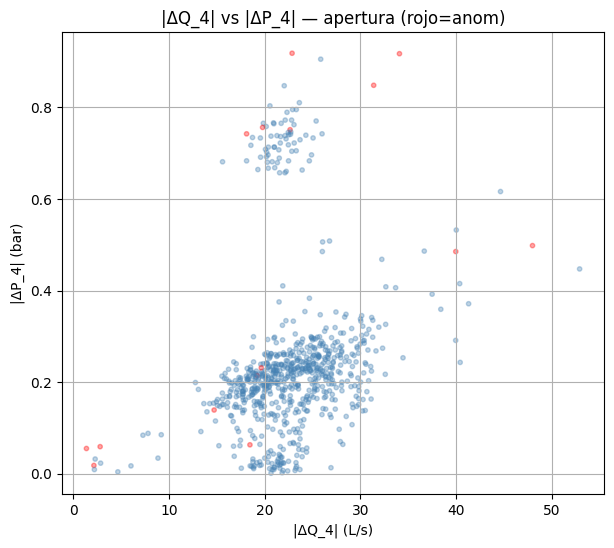

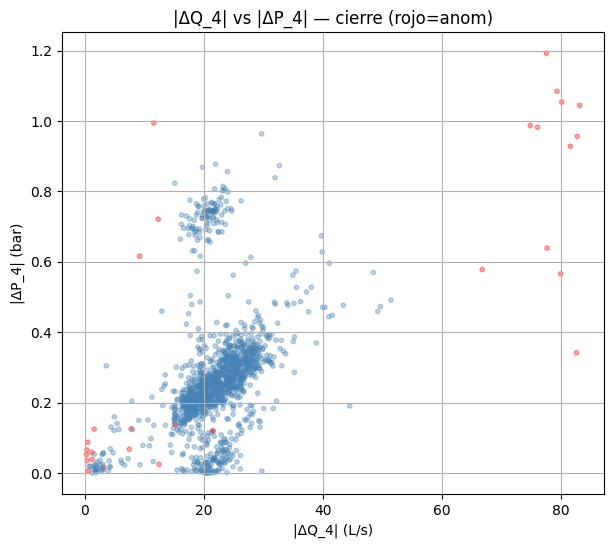

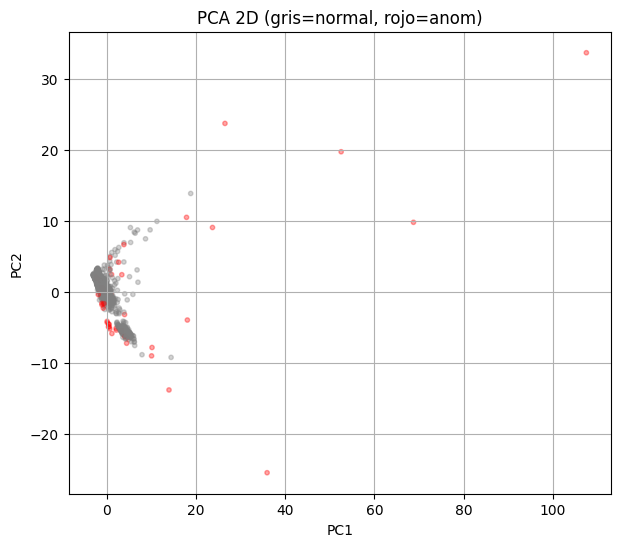

In [8]:
if labeled.empty:
    print('No se ajustó ningún modelo (subconjuntos con n<MIN_N). Ajusta MIN_N o revisa datos.')
else:
    anom_tab = labeled.groupby(['type','family'])['if_anom'].agg(['count','sum'])
    anom_tab['frac_anom'] = anom_tab['sum']/anom_tab['count']
    display(anom_tab)

    # top outliers globales
    top = labeled.sort_values('if_score').head(15)
    display(top[['type','family','start','duration_min','abs_dQ4','abs_dP4','abs_dQ16','abs_dP16','R_persist','a_app_4_ms','if_score','if_anom']])

    # scatter ΔQ4 vs ΔP4
    for typ in ['apertura','cierre']:
        sub = labeled[labeled['type']==typ].copy()
        if len(sub) > 30000:
            sub = sub.sample(30000, random_state=42)

        plt.figure(figsize=(7,6))
        c = np.where(sub['if_anom'], 'red', 'steelblue')
        plt.scatter(sub['abs_dQ4'], sub['abs_dP4'], s=10, alpha=0.35, c=c)
        plt.xlabel('|ΔQ_4| (L/s)')
        plt.ylabel('|ΔP_4| (bar)')
        plt.title(f'|ΔQ_4| vs |ΔP_4| — {typ} (rojo=anom)')
        plt.show()

    # PCA (solo para visualizar)
    # tomamos un subconjunto para no cargar memoria
    vis = labeled.copy()
    feat_vis = ['abs_dQ4','abs_dP4','abs_dQ16','abs_dP16','duration_min','R_persist','a_app_4_ms']
    vis = vis[feat_vis + ['type','family','if_anom']].replace([np.inf,-np.inf], np.nan).dropna()
    if len(vis) > 40000:
        vis = vis.sample(40000, random_state=42)

    X = RobustScaler().fit_transform(vis[feat_vis].values)
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(7,6))
    c = np.where(vis['if_anom'].values, 'red', 'gray')
    plt.scatter(Z[:,0], Z[:,1], s=10, alpha=0.35, c=c)
    plt.title('PCA 2D (gris=normal, rojo=anom)')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()


## 8) Guardar salidas

- `eventos_iforest_labeled.parquet`: eventos modelados con score/flag
- `iforest_anomalias.parquet`: solo anómalos (para revisar y para el notebook final)


In [9]:
if not labeled.empty:
    OUT_LABELED.parent.mkdir(parents=True, exist_ok=True)
    OUT_ANOMS.parent.mkdir(parents=True, exist_ok=True)

    labeled.to_parquet(OUT_LABELED, index=False)
    anoms = labeled[labeled['if_anom']].sort_values('if_score')
    anoms.to_parquet(OUT_ANOMS, index=False)

    OUT_LABELED, OUT_ANOMS, anoms.shape
else:
    print('No hay labeled para guardar.')


## Resumen automático 

La siguiente celda imprime:
- conteos por tipo/familia
- percentiles de magnitudes y $a_{app,4}$
- ciclos apertura→cierre y distribución de amplitud
- conteo de anomalías y top 10
- rutas de salida


In [10]:
print('=== RESUMEN DATASET (04) ===')
print('\nInputs:')
print('HORIZ_FILE:', HORIZ_FILE)
print('EVENTS_FILE:', EVENTS_FILE)

print('\nGeometría:')
print('D (m):', D)
print('A (m^2):', float(A))
print('rho_f (kg/m3):', rho_f)

print('\nConteos:')
print('n_total_eventos:', int(len(df)))
print('por tipo:', df['type'].value_counts().to_dict())
print('por tipo/familia:')
print((df.groupby(['type','family']).size()).to_dict())

print('\nMagnitudes (abs) — percentiles globales:')
for col in ['abs_dQ4','abs_dP4','abs_dQ16','abs_dP16','R_persist','a_app_4_ms']:
    s = df[col].replace([np.inf,-np.inf], np.nan).dropna()
    if len(s):
        q = s.quantile([0.5,0.9,0.95,0.99,0.999]).to_dict()
        print(col, q)

print('\nCiclos apertura→cierre (pulso) <=60 min:')
if 'paired_valid' in globals() and len(paired_valid):
    print('n_pares:', int(len(paired_valid)))
    q = paired_valid['dP_cycle_bar'].dropna().quantile([0.5,0.9,0.95,0.99]).to_dict()
    print('ΔP_cycle_bar quantiles:', q)
else:
    print('n_pares: 0')

print('\nIsolation Forest:')
if 'labeled' in globals() and not labeled.empty:
    print('Subconjuntos modelados:', list(models.keys()))
    anom_counts = labeled.groupby(['type','family'])['if_anom'].sum().to_dict()
    print('anom por tipo/familia:', anom_counts)
    print('n_anom total:', int(labeled['if_anom'].sum()))

    top10 = labeled[labeled['if_anom']].sort_values('if_score').head(10)
    if len(top10):
        print('\nTop 10 anómalos (más score bajo):')
        display(top10[['type','family','start','duration_min','abs_dQ4','abs_dP4','abs_dQ16','abs_dP16','R_persist','a_app_4_ms','if_score']])
else:
    print('No se ajustaron modelos o labeled vacío.')

print('\nOutputs:')
print('OUT_LABELED:', OUT_LABELED)
print('OUT_ANOMS:', OUT_ANOMS)
print('=== FIN ===')


=== RESUMEN DATASET (04) ===

Inputs:
HORIZ_FILE: /home/maxi/datascience_esval/data/processed/eventos_apertura_cierre_horizontes.parquet
EVENTS_FILE: /home/maxi/datascience_esval/data/processed/eventos_apertura_cierre.parquet

Geometría:
D (m): 0.315
A (m^2): 0.07793113276311181
rho_f (kg/m3): 1000.0

Conteos:
n_total_eventos: 2658
por tipo: {'cierre': 1555, 'apertura': 1103}
por tipo/familia:
{('apertura', 'intermedio'): 159, ('apertura', 'na'): 17, ('apertura', 'persistente'): 172, ('apertura', 'pulso'): 755, ('cierre', 'intermedio'): 66, ('cierre', 'na'): 20, ('cierre', 'persistente'): 1417, ('cierre', 'pulso'): 52}

Magnitudes (abs) — percentiles globales:
abs_dQ4 {0.5: 21.835, 0.9: 28.282000000000007, 0.95: 30.58, 0.99: 62.86380000000109, 0.999: 83.65}
abs_dP4 {0.5: 0.22806345240000003, 0.9: 0.4861352538000001, 0.95: 0.7332039939000001, 0.99: 0.9178453652970001, 0.999: 1.2774584177649064}
abs_dQ16 {0.5: 17.709999999999994, 0.9: 27.070000000000007, 0.95: 30.00999999999999, 0.99: 62

,type,family,start,duration_min,abs_dQ4,abs_dP4,abs_dQ16,abs_dP16,R_persist,a_app_4_ms,if_score
1178,cierre,persistente,2025-04-16 01:59:00,3.0,83.09,1.044291,83.01,1.023285,0.999037,97.945294,-0.137112
1501,cierre,persistente,2025-07-03 09:34:00,3.0,79.28,1.084302,80.28,1.091304,1.012614,106.585341,-0.134020
1944,cierre,persistente,2025-10-11 22:35:00,6.0,77.50,1.192332,78.34,1.170326,1.010839,119.896468,-0.118232
1899,cierre,persistente,2025-10-02 18:03:00,3.0,74.80,0.987275,74.60,0.962268,0.997326,102.860206,-0.115017
871,cierre,persistente,2025-02-01 09:12:00,4.0,76.01,0.982273,75.47,0.968269,0.992896,100.709999,-0.111913
1941,cierre,persistente,2025-10-11 00:14:00,5.0,80.08,1.053293,81.36,1.022284,1.015984,102.502898,-0.111608
993,cierre,persistente,2025-02-26 01:32:00,4.0,81.53,0.928258,82.44,0.916255,1.011162,88.728343,-0.110761
1200,cierre,persistente,2025-04-23 02:19:00,4.0,82.68,0.956266,83.18,0.951265,1.006047,90.134128,-0.106695
1707,cierre,persistente,2025-08-25 16:43:00,13.0,0.26,0.053015,24.79,0.254071,95.346154,1589.038274,-0.101218
1098,cierre,persistente,2025-03-25 00:51:00,3.0,79.90,0.566158,80.95,0.592165,1.013141,55.220647,-0.082850



Outputs:
OUT_LABELED: /home/maxi/datascience_esval/data/processed/eventos_iforest_labeled.parquet
OUT_ANOMS: /home/maxi/datascience_esval/data/processed/iforest_anomalias.parquet
=== FIN ===
